# AMPLPY: Pattern Generation

Documentation: http://amplpy.readthedocs.io

GitHub Repository: https://github.com/ampl/amplpy

PyPI Repository: https://pypi.python.org/pypi/amplpy

### Imports

In [1]:
from __future__ import print_function
from amplpy import AMPL
from math import floor
import os

### Basic pattern-cutting model

In [2]:
with open(os.path.join('models', 'cut.mod'), 'r') as f:
    print(f.read())

param nPatterns integer > 0;
set PATTERNS = 1..nPatterns; # patterns
set WIDTHS; # finished widths
param order {WIDTHS} >= 0; # rolls of width j ordered
param overrun; # permitted overrun on any width
param rolls {WIDTHS,PATTERNS} >= 0 default 0; # rolls of width i in pattern j

var Cut {PATTERNS} integer >= 0; # raw rolls to cut in each pattern

minimize TotalRawRolls: sum {p in PATTERNS} Cut[p];

subject to FinishedRollLimits {w in WIDTHS}:
  order[w] <= sum {p in PATTERNS} rolls[w,p] * Cut[p] <= order[w] + overrun;



### Plotting routine

In [3]:
def cuttingPlot(roll_width, widths, solution):
    import numpy as np
    import matplotlib.pyplot as plt
    ind = np.arange(len(solution))
    acc = [0]*len(solution)
    for p, (patt, rep) in enumerate(solution):
        for i in range(len(widths)):
            for j in range(patt[i]):
                vec = [0]*len(solution)
                vec[p] = widths[i]
                plt.bar(ind, vec, width=0.35, bottom=acc)
                acc[p] += widths[i]
    plt.title('Solution')
    plt.xticks(ind, tuple("x {:}".format(rep) for patt, rep in solution))
    plt.yticks(np.arange(0, roll_width, 10))
    plt.show()

### Set data

In [4]:
roll_width = 64.5
overrun = 6
orders = {
    6.77: 10,
    7.56: 40,
    17.46: 33,
    18.76: 10
}
widths = list(sorted(orders.keys(), reverse=True))

### Set up AMPL model

In [5]:
# Initialize
ampl = AMPL()
ampl.read(os.path.join('models', 'cut.mod'))

### Send data to AMPL (Java/C++ style)

In [6]:
# Send scalar values
ampl.getParameter('overrun').set(overrun)
ampl.getParameter('nPatterns').set(len(widths))
# Send order vector
ampl.getSet('WIDTHS').setValues(widths)
ampl.getParameter('order').setValues(orders)
# Generate and send initial pattern matrix
ampl.getParameter('rolls').setValues({
    (widths[i], 1+i): int(floor(roll_width/widths[i]))
    for i in range(len(widths))
})

### Send data to AMPL (alternative style)

In [7]:
# Send scalar values
ampl.param['overrun'] = overrun
ampl.param['nPatterns'] = len(widths)
# Send order vector
ampl.set['WIDTHS'] = widths
ampl.param['order'] = orders
# Generate and send initial pattern matrix
ampl.param['rolls'] = {
    (widths[i], 1+i): int(floor(roll_width/widths[i]))
    for i in range(len(widths))
}

### Set up for generation loop

In [8]:
# Set solve options
ampl.option['solver'] = 'gurobi'
ampl.option['relax_integrality'] =  1

# Create a param for sending AMPL new patterns
ampl.eval('param newpat {WIDTHS} integer >= 0;')
new_pattern = ampl.param['newpat']

### Define the knapsack subproblem

In [9]:
# Define the knapsack subproblem
subprob = AMPL()
subprob.option['solver'] = 'gurobi'
subprob.eval('''
    set WIDTHS;
    param W >= 0;
    param v{WIDTHS} >= 0;
    var x{WIDTHS} integer >= 0;
    maximize profit: sum {w in WIDTHS} v[w]*x[w];
    subject to capacity: sum {w in WIDTHS} w*x[w] <= W;
''')
subprob.set['WIDTHS'] = widths
subprob.param['W'] = roll_width
values = subprob.param['v']
kpsolution = subprob.var['x']
profit = subprob.obj['profit']

### Loop

In [10]:
limits = ampl.getConstraint('FinishedRollLimits')
while True:
    print('Master problem:')
    ampl.solve()
    print()

    # Retrieve duals & look for new pattern
    # Solve knapsack problem for potential new pattern
    values.setValues(limits.getValues())
    print('Subproblem:')
    subprob.solve()
    print()
    if profit.value() <= 1.000001:
        break

    # Send new pattern to AMPL
    new_pattern.setValues(kpsolution.getValues())
    ampl.eval('let nPatterns := nPatterns + 1;')
    ampl.eval('let {w in WIDTHS} rolls[w, nPatterns] := newpat[w];')

Master problem:
Gurobi 7.5.1: optimal solution; objective 20.44444444

Subproblem:
Gurobi 7.5.1: optimal solution; objective 1.152777
2 simplex iterations
1 branch-and-cut nodes

Master problem:
Gurobi 7.5.1: optimal solution; objective 18.77777778
1 simplex iterations

Subproblem:
Gurobi 7.5.1: optimal solution; objective 1.11111
1 simplex iterations
1 branch-and-cut nodes

Master problem:
Gurobi 7.5.1: optimal solution; objective 18.375
3 simplex iterations

Subproblem:
Gurobi 7.5.1: optimal solution; objective 1.124999
1 simplex iterations
1 branch-and-cut nodes

Master problem:
Gurobi 7.5.1: optimal solution; objective 17.95833333
5 simplex iterations

Subproblem:
Gurobi 7.5.1: optimal solution; objective 1.041667
5 simplex iterations
1 branch-and-cut nodes

Master problem:
Gurobi 7.5.1: optimal solution; objective 17.94117647
5 simplex iterations

Subproblem:
Gurobi 7.5.1: optimal solution; objective 1.000001
1 simplex iterations
1 branch-and-cut nodes



### Compute and display integer solution

Gurobi 7.5.1: optimal solution; objective 19
5 simplex iterations
[0.0, 0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 1.0]


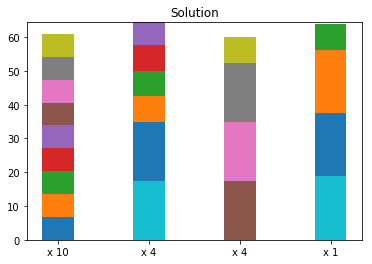

In [11]:
# Compute and display integer solution
ampl.option['relax_integrality'] = 0
ampl.solve()

# Retrieve solution
cutting_plan = ampl.var['Cut'].getValues()
cutvec = list(cutting_plan.getColumn('Cut.val'))
print(cutvec)

# Display solution
rolls = ampl.param['rolls']
npatterns = int(ampl.param['nPatterns'].value())
solution = [
    ([int(rolls[widths[i], p]) for i in range(len(widths))], int(cutvec[p]))
    for p in range(npatterns)
    if cutvec[p] > 0
]
cuttingPlot(roll_width, widths, solution)